In [150]:
import numpy as np 
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib import gridspec
import load_ship_data

In [151]:
np.random.seed(522)

In [152]:
# Load the data! 
filePath = './data/shipsnet.json'
trainingSet, testingSet, validationSet = load_ship_data.load_data_train_test_split(filePath)
train, labels_tr = trainingSet
train_flat = train.reshape(train.shape[0], 19200)
train_flat[0][:10]

Training Set Data Length:  2800   Label Length:  2800
TestingSet Set Data Length:  600  Label Length:  600
Validation Set Data Length:  600  Label Length:  600


array([102,  99,  99, 103, 104, 100, 104, 105, 103, 108], dtype=uint8)

In [153]:
Xtrain=trainingSet[0]
ytrain=trainingSet[1]
Xtest=testingSet[0]
ytest=testingSet[1]
Xvalid=validationSet[0]
yvalid=validationSet[1]
Xtrain=Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]*Xtrain.shape[3])
Xtest=Xtest.reshape(Xtest.shape[0],Xtest.shape[1]*Xtest.shape[2]*Xtest.shape[3])
Xvalid=Xvalid.reshape(Xvalid.shape[0],Xvalid.shape[1]*Xvalid.shape[2]*Xvalid.shape[3])

### Random Forest Implementation / Experimentation

In [154]:
from sklearn.ensemble import RandomForestClassifier
import time



In [155]:
def calculatePredictedVsActual(predicted, actual): 
    correctlyPredictedShips = 0
    correctlyPredictedNotShips = 0
    
    for i in np.arange(len(predicted)): 
        if (predicted[i] == 0 and actual[i] == 0): 
            correctlyPredictedNotShips = correctlyPredictedNotShips + 1
        elif (predicted[i] == 1 and actual[i] == 1): 
            correctlyPredictedShips = correctlyPredictedShips + 1
            
    totalShore = len(actual[ actual == 0 ])
    totalShips = len(actual[ actual == 1 ])

    return (correctlyPredictedNotShips / totalShore, correctlyPredictedShips / totalShips) 
    
def runRandomForestClassifier(xTrain, yTrain, xTest, yTest): 
    clf = RandomForestClassifier(warm_start=True, verbose=1)
    startingTime = time.time()           # start time
    y_model = clf.fit(xTrain, yTrain)
    endingTime = time.time()           # ending time
    totalTime = endingTime - startingTime

    
    return (y_model.score(xTest, yTest), totalTime, clf.predict(xTest))


def doKFoldCrossValidationRandomForest(X, y, xTest, yTest):
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = runRandomForestClassifier(X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))

    return avg_acc


In [156]:
(basicRandomForestAccuracy, basicRandomForestRunTime, predicted) = runRandomForestClassifier(Xtrain, ytrain, Xtest, ytest)
kfoldAccRandomForest = doKFoldCrossValidationRandomForest(Xtrain, ytrain, Xtest, ytest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy from each fold =  [0.9392857142857143, 0.9428571428571428, 0.9642857142857143, 0.9642857142857143, 0.95, 0.9357142857142857, 0.95, 0.9464285714285714, 0.9607142857142857, 0.9178571428571428]
Average Accuracy = 0.9471428571428572


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [157]:
(class0Acc, class1Acc) = calculatePredictedVsActual(predicted, ytest)
print(f"""
basicRandomForestAccuracy {basicRandomForestAccuracy}
kfoldAccRandomForest {kfoldAccRandomForest}
class0Acc {class0Acc}, 
class1Acc {class1Acc}
""")



basicRandomForestAccuracy 0.96
kfoldAccRandomForest 0.9471428571428572
class0Acc 0.98, 
class1Acc 0.9



### PCA + Random Forest Implementation / Experimentation

In [158]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [114]:
def plotPCA(Xtrain, Xtest, ytrain, ytest):
    numComponentsList = [5, 10, 40, 50,75, 100, 250, 500, 700, 850, 1000, 2000, None]

    accuracyList = np.zeros(len(numComponentsList))
    runTimeList = np.zeros(len(numComponentsList))
    explainedList = np.zeros(len(numComponentsList))
    
    for i in np.arange(len(numComponentsList)): 
        pca = PCA(n_components=numComponentsList[i])
        pca.fit(Xtrain)
        pca_Xtrain= pca.transform(Xtrain)
        pca_Xtest = pca.transform(Xtest)
        explained=np.sum(pca.explained_variance_ratio_)
        print(explained)
        (pcaRandomForestAccuracy, pcaRandomForestRunTime, pcaPredicted) = runRandomForestClassifier(pca_Xtrain, ytrain, pca_Xtest, ytest)
        (class0, class1) = calculatePredictedVsActual(pcaPredicted, ytest)
        accuracyList[i] =pcaRandomForestAccuracy
        runTimeList[i] = pcaRandomForestRunTime
        explainedList[i] = explained
        print(f""" 
            PCA Components {numComponentsList[i]}
            pcaRandomForestAccuracy {pcaRandomForestAccuracy}
            pcaRandomForestRunTime {pcaRandomForestRunTime}
            explained {explained}
            class0 {class0}, 
            class1 {class1}
        
        """)
    fig, ax1= plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(numComponentsList, accuracyList, color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time', color=color)
    ax2.plot(numComponentsList, runTimeList, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title("PCA With Respect to Random Forest")
    return (accuracyList, runTimeList, explainedList)

0.6157238553120535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 5
            pcaRandomForestAccuracy 0.9116666666666666
            pcaRandomForestRunTime 0.9605951309204102
            explained 0.6157238553120535
            class0 0.96, 
            class1 0.7666666666666667
        
        
0.6997472370889533


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 10
            pcaRandomForestAccuracy 0.95
            pcaRandomForestRunTime 1.063364028930664
            explained 0.6997472370889533
            class0 0.9822222222222222, 
            class1 0.8533333333333334
        
        
0.8319549858282743


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


 
            PCA Components 40
            pcaRandomForestAccuracy 0.965
            pcaRandomForestRunTime 2.074150800704956
            explained 0.8319549858282743
            class0 0.9977777777777778, 
            class1 0.8666666666666667
        
        
0.849901026343648


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 50
            pcaRandomForestAccuracy 0.96
            pcaRandomForestRunTime 1.7937610149383545
            explained 0.849901026343648
            class0 0.9955555555555555, 
            class1 0.8533333333333334
        
        
0.880609851040148


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 75
            pcaRandomForestAccuracy 0.965
            pcaRandomForestRunTime 1.6277213096618652
            explained 0.880609851040148
            class0 0.9977777777777778, 
            class1 0.8666666666666667
        
        
0.9003295274163259


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 100
            pcaRandomForestAccuracy 0.9516666666666667
            pcaRandomForestRunTime 2.3237059116363525
            explained 0.9003295274163259
            class0 0.9955555555555555, 
            class1 0.82
        
        
0.9535107579466414


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 250
            pcaRandomForestAccuracy 0.9433333333333334
            pcaRandomForestRunTime 2.9054291248321533
            explained 0.9535107579466414
            class0 1.0, 
            class1 0.7733333333333333
        
        
0.980248322258303


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 500
            pcaRandomForestAccuracy 0.9183333333333333
            pcaRandomForestRunTime 4.390632390975952
            explained 0.980248322258303
            class0 1.0, 
            class1 0.6733333333333333
        
        
0.9882372750298958


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


 
            PCA Components 700
            pcaRandomForestAccuracy 0.9
            pcaRandomForestRunTime 5.901299953460693
            explained 0.9882372750298958
            class0 1.0, 
            class1 0.6
        
        
0.991564817446791


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 850
            pcaRandomForestAccuracy 0.8933333333333333
            pcaRandomForestRunTime 6.02516770362854
            explained 0.991564817446791
            class0 1.0, 
            class1 0.5733333333333334
        
        
0.9937807978734744


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 1000
            pcaRandomForestAccuracy 0.8833333333333333
            pcaRandomForestRunTime 6.218578815460205
            explained 0.9937807978734744
            class0 1.0, 
            class1 0.5333333333333333
        
        
0.9991700833210535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 2000
            pcaRandomForestAccuracy 0.7633333333333333
            pcaRandomForestRunTime 12.754895210266113
            explained 0.9991700833210535
            class0 0.9177777777777778, 
            class1 0.3
        
        
1.0000000000000002


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components None
            pcaRandomForestAccuracy 0.7116666666666667
            pcaRandomForestRunTime 15.396730899810791
            explained 1.0000000000000002
            class0 0.8177777777777778, 
            class1 0.3933333333333333
        
        


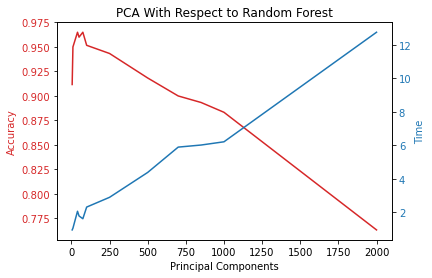

In [115]:
allVals = plotPCA(Xtrain, Xtest, ytrain, ytest)


kfolds! 

In [86]:
def doKFoldCrossValidation(xTrain, yTrain, xValid, yValid, xTest, yTest, model):
    pca2 = PCA(n_components=50)
    Xtrain=np.concatenate((xTrain,xValid))
    ytrain=np.concatenate((yTrain,yValid))
    pca2.fit(Xtrain)
    pca2_Xtrain=pca2.transform(Xtrain)
    pca2_Xtest=pca2.transform(Xtest)
    explained=np.sum(pca2.explained_variance_ratio_)
    print(explained)
    X=pca2_Xtrain
    y=ytrain
    print(X.shape)
    print(y.shape)
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = model(X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))
    
def doKFoldCrossValidationBPNN(X, y, xTest, yTest, model, bpnnModel):
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = model(bpnnModel, X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))

    return avg_acc


In [41]:
doKFoldCrossValidation(Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest, runRandomForestClassifier)

0.8469330708334136
(3400, 50)
(3400,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy from each fold =  [0.9764705882352941, 0.9676470588235294, 0.9647058823529412, 0.9764705882352941, 0.961764705882353, 0.9588235294117647, 0.961764705882353, 0.9558823529411765, 0.9529411764705882, 0.9529411764705882]
Average Accuracy = 0.9629411764705882


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### BPNN Implementation / Experimentation

In [42]:
from sklearn.neural_network import MLPClassifier  


In [43]:
bpnnClassifier_sgd = MLPClassifier(solver='sgd')
bpnnClassifier_lbfgs = MLPClassifier(solver='lbfgs')
bpnnWith1000Hidden_sgd = MLPClassifier(solver='sgd', hidden_layer_sizes=(1000,))
bpnnWith1000Hidden_lbfgs = MLPClassifier(solver='lbfgs',  hidden_layer_sizes=(1000,))
bpnnWith1000x1000Hidden_sgd = MLPClassifier(solver='sgd', hidden_layer_sizes=(1000,1000))
bpnnWith1000x1000Hidden_lbfgs = MLPClassifier(solver='lbfgs',  hidden_layer_sizes=(1000,1000))


In [44]:
def runBPNNandTime(classifier, xTrain, yTrain, xTest, yTest): 
    startingTime = time.time()           # start time
    y_model = classifier.fit(xTrain, yTrain)
    endingTime = time.time()           # ending time
    totalTime = endingTime - startingTime
    
    return (y_model.score(xTest, yTest), totalTime, y_model.predict(xTest))
    


In [45]:
xTrain = np.concatenate((Xtrain,Xvalid))
yTrain = np.concatenate((ytrain, yvalid))

(bpnnClassifier_sgd_accuracy, bpnnClassifier_sgd_time, bpnnClassifier_sgd_predicted) = runBPNNandTime(bpnnClassifier_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnClassifier_lbfgs_accuracy, bpnnClassifier_lbfgs_time, bpnnClassifier_lbfgs_predicted) = runBPNNandTime(bpnnClassifier_lbfgs, xTrain, yTrain, Xtest, ytest)

(bpnnWith1000Hidden_sgd_accuracy, bpnnWith1000Hidden_sgd_time, bpnnWith1000Hidden_sgd_predicted) = runBPNNandTime(bpnnWith1000Hidden_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnWith1000Hidden_lbfgs_accuracy, bpnnWith1000Hidden_lbfgs_time, bpnnWith1000Hidden_lbfgs_predicted) = runBPNNandTime(bpnnWith1000Hidden_lbfgs, xTrain, yTrain, Xtest, ytest)

(bpnnWith1000x1000Hidden_sgd_accuracy, bpnnWith1000x1000Hidden_sgd_time, bpnnWith1000x1000Hidden_sgd_predicted) = runBPNNandTime(bpnnWith1000x1000Hidden_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy, bpnnWith1000x1000Hidden_lbfgs_time, bpnnWith1000x1000Hidden_lbfgs_predicted) = runBPNNandTime(bpnnWith1000x1000Hidden_lbfgs, xTrain, yTrain, Xtest, ytest)






/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [98]:
np.save('bpnnPredicted', bpnnWith1000Hidden_lbfgs_predicted)

In [118]:
print(f"""
bpnnClassifier_sgd_accuracy: {bpnnClassifier_sgd_accuracy}    
bpnnClassifier_sgd_time: {bpnnClassifier_sgd_time}
bpnnClassifier_sgd_predicted {calculatePredictedVsActual(bpnnClassifier_sgd_predicted, ytest)}

bpnnWith1000Hidden_sgd_accuracy: {bpnnWith1000Hidden_sgd_accuracy}
bpnnWith1000Hidden_sgd_time: {bpnnWith1000Hidden_sgd_time}
bpnnWith1000Hidden__sgd_predicted {calculatePredictedVsActual(bpnnWith1000Hidden_sgd_predicted, ytest)}


bpnnWith1000x1000Hidden_sgd_accuracy: {bpnnWith1000x1000Hidden_sgd_accuracy}
bpnnWith1000x1000Hidden_sgd_time: {bpnnWith1000x1000Hidden_sgd_time}
bpnnWith1000x1000Hidden_sgd_predicted: {calculatePredictedVsActual(bpnnWith1000x1000Hidden_sgd_predicted, ytest)}



bpnnClassifier_lbfgs_accuracy: {bpnnClassifier_lbfgs_accuracy}
bpnnClassifier_lbfgs_time: {bpnnClassifier_lbfgs_time}
bpnnClassifier_lbfgs_predicted {calculatePredictedVsActual(bpnnClassifier_lbfgs_predicted, ytest)}

bpnnWith1000Hidden_lbfgs_accuracy: {bpnnWith1000Hidden_lbfgs_accuracy}
bpnnWith1000Hidden_lbfgs_time: {bpnnWith1000Hidden_lbfgs_time}
bpnnWith1000Hidden_lbfgs_predicted {calculatePredictedVsActual(bpnnWith1000Hidden_lbfgs_predicted, ytest)}


bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy: {bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy}
bpnnWith1000x1000Hidden_lbfgs_time: {bpnnWith1000x1000Hidden_lbfgs_time}
bpnnWith1000x1000Hidden_lbfgs_predicted {calculatePredictedVsActual(bpnnWith1000x1000Hidden_lbfgs_predicted, ytest)}

""")


bpnnClassifier_sgd_accuracy: 0.75    
bpnnClassifier_sgd_time: 34.72964096069336
bpnnClassifier_sgd_predicted (1.0, 0.0)

bpnnWith1000Hidden_sgd_accuracy: 0.75
bpnnWith1000Hidden_sgd_time: 1517.6399581432343
bpnnWith1000Hidden__sgd_predicted (1.0, 0.0)


bpnnWith1000x1000Hidden_sgd_accuracy: 0.75
bpnnWith1000x1000Hidden_sgd_time: 318.50302481651306
bpnnWith1000x1000Hidden_sgd_predicted: (1.0, 0.0)



bpnnClassifier_lbfgs_accuracy: 0.9516666666666667
bpnnClassifier_lbfgs_time: 698.9334049224854
bpnnClassifier_lbfgs_predicted (0.9644444444444444, 0.9133333333333333)

bpnnWith1000Hidden_lbfgs_accuracy: 0.95
bpnnWith1000Hidden_lbfgs_time: 4586.67370223999
bpnnWith1000Hidden_lbfgs_predicted (0.9666666666666667, 0.9)


bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy: 0.75
bpnnWith1000x1000Hidden_lbfgs_time: 613.7555248737335
bpnnWith1000x1000Hidden_lbfgs_predicted (1.0, 0.0)




### PCA + BPNN Implementation / Experimentation

In [94]:
def plotPCABpnn(Xtrain, Xtest, ytrain, ytest, model):
    numComponentsList = [5, 10, 40, 50,75, 100, 250, 500, 850, 1000,  2000 ]

    accuracyList = np.zeros(len(numComponentsList))
    runTimeList = np.zeros(len(numComponentsList))
    explainedList = np.zeros(len(numComponentsList))
    kfoldsList = np.zeros(len(numComponentsList))
    
    for i in np.arange(len(numComponentsList)): 
        pca = PCA(n_components=numComponentsList[i])
        pca.fit(Xtrain)
        pca_Xtrain= pca.transform(Xtrain)
        pca_Xtest = pca.transform(Xtest)
        explained=np.sum(pca.explained_variance_ratio_)
        print(explained)
        (pcaBPNNAccuracy, pcaBPNNRuntime, pcaPredicted) = runBPNNandTime(model, pca_Xtrain, ytrain, pca_Xtest, ytest)
        kfoldAcc = doKFoldCrossValidationBPNN(pca_Xtrain, ytrain, pca_Xtest, ytest, runBPNNandTime, model)


        accuracyList[i] = pcaBPNNAccuracy
        runTimeList[i] = pcaBPNNRuntime
        explainedList[i] = explained
        kfoldsList[i] = kfoldAcc
        print(f""" 
            PCA Components {numComponentsList[i]}
            pcaRandomForestAccuracy {pcaBPNNAccuracy}
            pcaRandomForestRunTime {pcaBPNNRuntime}
            kfoldAcc       {kfoldAcc}
            explained      {explained}
        
        """)
    fig, ax1= plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(numComponentsList, accuracyList, color, label='Accuracy')
    ax1.plot(numComponentsList, kfoldsList, color='green', label='kFolds Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time', color=color)
    ax2.plot(numComponentsList, runTimeList, color=color, label='Run Time')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.show()
    
    
    return (accuracyList, runTimeList, explainedList, kfoldsList)

0.6123770720379262
Accuracy from each fold =  [0.5470588235294118, 0.8088235294117647, 0.8117647058823529, 0.7735294117647059, 0.75, 0.7558823529411764, 0.7617647058823529, 0.7529411764705882, 0.7147058823529412, 0.7823529411764706]
Average Accuracy = 0.7458823529411764
 
            PCA Components 5
            pcaRandomForestAccuracy 0.7516666666666667
            pcaRandomForestRunTime 0.6422772407531738
            kfoldAcc       0.7458823529411764
            explained      0.6123770720379262
        
        
0.6962138577806515
Accuracy from each fold =  [0.7852941176470588, 0.8205882352941176, 0.8352941176470589, 0.85, 0.8088235294117647, 0.8029411764705883, 0.75, 0.7911764705882353, 0.5617647058823529, 0.7941176470588235]
Average Accuracy = 0.78
 
            PCA Components 10
            pcaRandomForestAccuracy 0.8516666666666667
            pcaRandomForestRunTime 0.45040392875671387
            kfoldAcc       0.78
            explained      0.6962138577806515
        
       

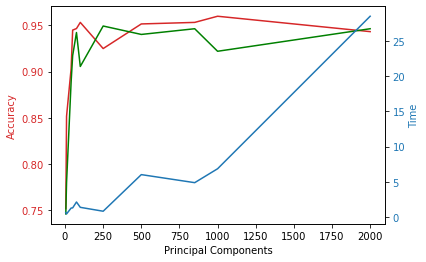

In [95]:
pcaValuesSGD = plotPCABpnn(xTrain, Xtest, yTrain, ytest, bpnnClassifier_sgd)


0.6123770719655677


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471:

Accuracy from each fold =  [0.8147058823529412, 0.8647058823529412, 0.8764705882352941, 0.8911764705882353, 0.8411764705882353, 0.8117647058823529, 0.8558823529411764, 0.8676470588235294, 0.8382352941176471, 0.8205882352941176]
Average Accuracy = 0.8482352941176469
 
            PCA Components 5
            pcaRandomForestAccuracy 0.795
            pcaRandomForestRunTime 1.357267141342163
            kfoldAcc       0.8482352941176469
            explained      0.6123770719655677
        
        
0.6962141583191142


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perce

Accuracy from each fold =  [0.9058823529411765, 0.8205882352941176, 0.8470588235294118, 0.9441176470588235, 0.8088235294117647, 0.9352941176470588, 0.95, 0.9264705882352942, 0.6852941176470588, 0.9147058823529411]
Average Accuracy = 0.8738235294117647
 
            PCA Components 10
            pcaRandomForestAccuracy 0.9216666666666666
            pcaRandomForestRunTime 2.5542759895324707
            kfoldAcc       0.8738235294117647
            explained      0.6962141583191142
        
        
0.8288717091312239


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.95, 0.9735294117647059, 0.9529411764705882, 0.9735294117647059, 0.9529411764705882, 0.9470588235294117, 0.95, 0.9647058823529412, 0.961764705882353, 0.7294117647058823]
Average Accuracy = 0.9355882352941176
 
            PCA Components 40
            pcaRandomForestAccuracy 0.9483333333333334
            pcaRandomForestRunTime 1.9216020107269287
            kfoldAcc       0.9355882352941176
            explained      0.8288717091312239
        
        
0.8469261408453048


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.95, 0.9558823529411765, 0.9529411764705882, 0.9411764705882353, 0.9470588235294117, 0.9529411764705882, 0.9558823529411765, 0.9676470588235294, 0.9647058823529412, 0.9529411764705882]
Average Accuracy = 0.9541176470588235
 
            PCA Components 50
            pcaRandomForestAccuracy 0.9533333333333334
            pcaRandomForestRunTime 1.42130708694458
            kfoldAcc       0.9541176470588235
            explained      0.8469261408453048
        
        
0.8777188826847161


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.961764705882353, 0.9647058823529412, 0.9647058823529412, 0.9647058823529412, 0.8441176470588235, 0.9470588235294117, 0.9588235294117647, 0.9470588235294117, 0.9676470588235294, 0.9529411764705882]
Average Accuracy = 0.9473529411764707
 
            PCA Components 75
            pcaRandomForestAccuracy 0.965
            pcaRandomForestRunTime 2.004201889038086
            kfoldAcc       0.9473529411764707
            explained      0.8777188826847161
        
        
0.8973785107689703


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.7470588235294118, 0.9441176470588235, 0.9588235294117647, 0.9705882352941176, 0.6529411764705882, 0.95, 0.9647058823529412, 0.9588235294117647, 0.9588235294117647, 0.9764705882352941]
Average Accuracy = 0.908235294117647
 
            PCA Components 100
            pcaRandomForestAccuracy 0.9616666666666667
            pcaRandomForestRunTime 3.0850863456726074
            kfoldAcc       0.908235294117647
            explained      0.8973785107689703
        
        
0.9507540086948295


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceW

Accuracy from each fold =  [0.9588235294117647, 0.9558823529411765, 0.9529411764705882, 0.961764705882353, 0.961764705882353, 0.9470588235294117, 0.9588235294117647, 0.9441176470588235, 0.9529411764705882, 0.9529411764705882]
Average Accuracy = 0.9547058823529412
 
            PCA Components 250
            pcaRandomForestAccuracy 0.7233333333333334
            pcaRandomForestRunTime 0.7850320339202881
            kfoldAcc       0.9547058823529412
            explained      0.9507540086948295
        
        
0.9782160837542779
Accuracy from each fold =  [0.961764705882353, 0.961764705882353, 0.9676470588235294, 0.9529411764705882, 0.9382352941176471, 0.9558823529411765, 0.9558823529411765, 0.9588235294117647, 0.95, 0.9647058823529412]
Average Accuracy = 0.956764705882353
 
            PCA Components 500
            pcaRandomForestAccuracy 0.96
            pcaRandomForestRunTime 3.333822011947632
            kfoldAcc       0.956764705882353
            explained      0.978216083754277

/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9529411764705882, 0.9470588235294117, 0.95, 0.9470588235294117, 0.961764705882353, 0.95, 0.9558823529411765, 0.9470588235294117, 0.9529411764705882, 0.9529411764705882]
Average Accuracy = 0.951764705882353
 
            PCA Components 850
            pcaRandomForestAccuracy 0.9616666666666667
            pcaRandomForestRunTime 4.470503807067871
            kfoldAcc       0.951764705882353
            explained      0.9901868277769442
        
        
0.9925689266435085


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceW

Accuracy from each fold =  [0.9588235294117647, 0.9588235294117647, 0.9558823529411765, 0.95, 0.9558823529411765, 0.9470588235294117, 0.9558823529411765, 0.9558823529411765, 0.9647058823529412, 0.9323529411764706]
Average Accuracy = 0.9535294117647058
 
            PCA Components 1000
            pcaRandomForestAccuracy 0.955
            pcaRandomForestRunTime 5.289336204528809
            kfoldAcc       0.9535294117647058
            explained      0.9925689266435085
        
        
0.998568181314712
Accuracy from each fold =  [0.9529411764705882, 0.9588235294117647, 0.9529411764705882, 0.9529411764705882, 0.961764705882353, 0.9558823529411765, 0.9529411764705882, 0.9470588235294117, 0.95, 0.9529411764705882]
Average Accuracy = 0.9538235294117647
 
            PCA Components 2000
            pcaRandomForestAccuracy 0.9583333333333334
            pcaRandomForestRunTime 6.994767904281616
            kfoldAcc       0.9538235294117647
            explained      0.998568181314712
       

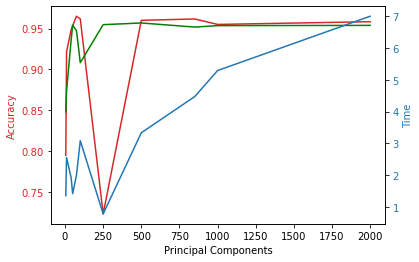

In [99]:
pcaValuesLBFGS = plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnClassifier_lbfgs)


0.6123770720196021
Accuracy from each fold =  [0.788235294117647, 0.7647058823529411, 0.7588235294117647, 0.8264705882352941, 0.8176470588235294, 0.7647058823529411, 0.8205882352941176, 0.8382352941176471, 0.6235294117647059, 0.7529411764705882]
Average Accuracy = 0.7755882352941176
 
            PCA Components 5
            pcaRandomForestAccuracy 0.795
            pcaRandomForestRunTime 1.0897552967071533
            kfoldAcc       0.7755882352941176
            explained      0.6123770720196021
        
        
0.6962140668732506
Accuracy from each fold =  [0.7705882352941177, 0.7852941176470588, 0.7470588235294118, 0.7823529411764706, 0.7617647058823529, 0.8794117647058823, 0.7294117647058823, 0.8323529411764706, 0.8264705882352941, 0.8117647058823529]
Average Accuracy = 0.7926470588235294
 
            PCA Components 10
            pcaRandomForestAccuracy 0.815
            pcaRandomForestRunTime 1.0618081092834473
            kfoldAcc       0.7926470588235294
            explaine

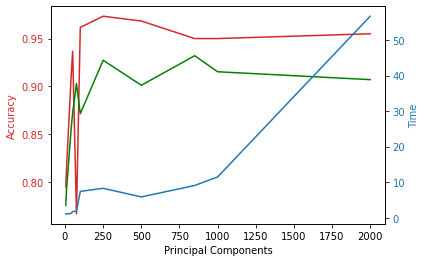

In [100]:
pcaValues_SGD_1000=plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnWith1000Hidden_sgd)


0.6123770720068848


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perce

Accuracy from each fold =  [0.9029411764705882, 0.8294117647058824, 0.9147058823529411, 0.8647058823529412, 0.8029411764705883, 0.8235294117647058, 0.9, 0.8911764705882353, 0.8558823529411764, 0.8176470588235294]
Average Accuracy = 0.8602941176470589
 
            PCA Components 5
            pcaRandomForestAccuracy 0.88
            pcaRandomForestRunTime 21.750534057617188
            kfoldAcc       0.8602941176470589
            explained      0.6123770720068848
        
        
0.6962138835385606


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perce

Accuracy from each fold =  [0.9470588235294117, 0.9352941176470588, 0.9647058823529412, 0.9529411764705882, 0.9323529411764706, 0.9441176470588235, 0.9470588235294117, 0.9529411764705882, 0.9470588235294117, 0.9558823529411765]
Average Accuracy = 0.9479411764705882
 
            PCA Components 10
            pcaRandomForestAccuracy 0.9466666666666667
            pcaRandomForestRunTime 25.341421842575073
            kfoldAcc       0.9479411764705882
            explained      0.6962138835385606
        
        
0.8288671545520405
Accuracy from each fold =  [0.9647058823529412, 0.9647058823529412, 0.9676470588235294, 0.961764705882353, 0.9705882352941176, 0.9470588235294117, 0.9558823529411765, 0.9647058823529412, 0.9705882352941176, 0.9588235294117647]
Average Accuracy = 0.9626470588235294
 
            PCA Components 40
            pcaRandomForestAccuracy 0.9666666666666667
            pcaRandomForestRunTime 10.667674779891968
            kfoldAcc       0.9626470588235294
            

/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9647058823529412, 0.9647058823529412, 0.9529411764705882, 0.9764705882352941, 0.9705882352941176, 0.9558823529411765, 0.9558823529411765, 0.9529411764705882, 0.9735294117647059, 0.9705882352941176]
Average Accuracy = 0.9638235294117647
 
            PCA Components 50
            pcaRandomForestAccuracy 0.9666666666666667
            pcaRandomForestRunTime 12.204248189926147
            kfoldAcc       0.9638235294117647
            explained      0.8468850431740925
        
        
0.8777074082360099


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.961764705882353, 0.961764705882353, 0.9529411764705882, 0.9794117647058823, 0.9735294117647059, 0.9558823529411765, 0.9529411764705882, 0.95, 0.9764705882352941, 0.9588235294117647]
Average Accuracy = 0.9623529411764705
 
            PCA Components 75
            pcaRandomForestAccuracy 0.9666666666666667
            pcaRandomForestRunTime 14.601109027862549
            kfoldAcc       0.9623529411764705
            explained      0.8777074082360099
        
        
0.8973736698055149


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.961764705882353, 0.9588235294117647, 0.9647058823529412, 0.9705882352941176, 0.95, 0.9558823529411765, 0.7411764705882353, 0.6970588235294117, 0.9588235294117647, 0.9705882352941176]
Average Accuracy = 0.9129411764705881
 
            PCA Components 100
            pcaRandomForestAccuracy 0.7833333333333333
            pcaRandomForestRunTime 3.1144657135009766
            kfoldAcc       0.9129411764705881
            explained      0.8973736698055149
        
        
0.9507598012138962
Accuracy from each fold =  [0.9676470588235294, 0.9647058823529412, 0.9588235294117647, 0.9705882352941176, 0.9647058823529412, 0.9529411764705882, 0.961764705882353, 0.9470588235294117, 0.9764705882352941, 0.9529411764705882]
Average Accuracy = 0.9617647058823529
 
            PCA Components 250
            pcaRandomForestAccuracy 0.9533333333333334
            pcaRandomForestRunTime 16.92387819290161
            kfoldAcc       0.9617647058823529
            explained     

/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9588235294117647, 0.6852941176470588, 0.9558823529411765, 0.9558823529411765, 0.9588235294117647, 0.9529411764705882, 0.95, 0.9529411764705882, 0.961764705882353, 0.9411764705882353]
Average Accuracy = 0.9273529411764706
 
            PCA Components 500
            pcaRandomForestAccuracy 0.9616666666666667
            pcaRandomForestRunTime 23.507589101791382
            kfoldAcc       0.9273529411764706
            explained      0.9782135501568487
        
        
0.9901890827844068


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9470588235294117, 0.9705882352941176, 0.9705882352941176, 0.9676470588235294, 0.9705882352941176, 0.9470588235294117, 0.9470588235294117, 0.9411764705882353, 0.9588235294117647, 0.95]
Average Accuracy = 0.9570588235294117
 
            PCA Components 850
            pcaRandomForestAccuracy 0.9583333333333334
            pcaRandomForestRunTime 39.70577096939087
            kfoldAcc       0.9570588235294117
            explained      0.9901890827844068
        
        
0.992570328686032


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9705882352941176, 0.9764705882352941, 0.9588235294117647, 0.9705882352941176, 0.9529411764705882, 0.9588235294117647, 0.961764705882353, 0.95, 0.9558823529411765, 0.9588235294117647]
Average Accuracy = 0.9614705882352942
 
            PCA Components 1000
            pcaRandomForestAccuracy 0.955
            pcaRandomForestRunTime 32.09671497344971
            kfoldAcc       0.9614705882352942
            explained      0.992570328686032
        
        
0.9985679827645426
Accuracy from each fold =  [0.961764705882353, 0.9705882352941176, 0.9529411764705882, 0.9647058823529412, 0.9676470588235294, 0.9352941176470588, 0.9705882352941176, 0.9647058823529412, 0.9588235294117647, 0.9676470588235294]
Average Accuracy = 0.961470588235294
 
            PCA Components 2000
            pcaRandomForestAccuracy 0.9583333333333334
            pcaRandomForestRunTime 89.56697702407837
            kfoldAcc       0.961470588235294
            explained      0.998567982764

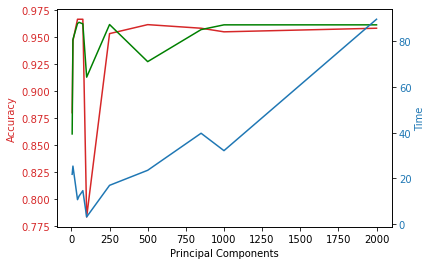

In [101]:
pcaValues_LBFGS_1000 = plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnWith1000Hidden_lbfgs)


In [145]:
def plotPCABpnnClasswise(Xtrain, Xtest, ytrain, ytest, model):
    numComponentsList = [50, 100, 250, 500 ]

    accuracyList = np.zeros(len(numComponentsList))
    runTimeList = np.zeros(len(numComponentsList))
    explainedList = np.zeros(len(numComponentsList))
    kfoldsList = np.zeros(len(numComponentsList))
    
    for i in np.arange(len(numComponentsList)): 
        pca = PCA(n_components=numComponentsList[i])
        pca.fit(Xtrain)
        pca_Xtrain= pca.transform(Xtrain)
 
        pca_Xtest = pca.transform(Xtest)
        explained=np.sum(pca.explained_variance_ratio_)
        print(explained)
 
        (pcaBPNNAccuracy, pcaBPNNRuntime, pcaPredicted) = runBPNNandTime(model, pca_Xtrain, ytrain, pca_Xtest, ytest)
        kfoldAcc = doKFoldCrossValidationBPNN(pca_Xtrain, ytrain, pca_Xtest, ytest, runBPNNandTime, model)


        accuracyList[i] = pcaBPNNAccuracy
        runTimeList[i] = pcaBPNNRuntime
        explainedList[i] = explained
        kfoldsList[i] = kfoldAcc
        print(f""" 
            PCA Components {numComponentsList[i]}
            pcaBPNNAccuracy {pcaBPNNAccuracy}
            pcaBPNNRunTime {pcaBPNNRuntime}
            kfoldAcc       {kfoldAcc}
            explained      {explained}
            predicted {calculatePredictedVsActual(pcaPredicted, ytest)}

        """)
    fig, ax1= plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(numComponentsList, accuracyList, color, label='Accuracy')
    ax1.plot(numComponentsList, kfoldsList, color='green', label='kFolds Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time', color=color)
    ax2.plot(numComponentsList, runTimeList, color=color, label='Run Time')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.show()
    
    
    return (accuracyList, runTimeList, explainedList, kfoldsList)

0.84986555676263
Accuracy from each fold =  [0.9071428571428571, 0.8821428571428571, 0.8785714285714286, 0.9142857142857143, 0.9642857142857143, 0.8642857142857143, 0.4607142857142857, 0.8928571428571429, 0.9607142857142857, 0.8035714285714286]
Average Accuracy = 0.8528571428571426
 
            PCA Components 50
            pcaBPNNAccuracy 0.9283333333333333
            pcaBPNNRunTime 2.341148853302002
            kfoldAcc       0.8528571428571426
            explained      0.84986555676263
            predicted (0.9622222222222222, 0.8266666666666667)

        
0.9003193894432843
Accuracy from each fold =  [0.8928571428571429, 0.8964285714285715, 0.9607142857142857, 0.9178571428571428, 0.9392857142857143, 0.9392857142857143, 0.8071428571428572, 0.9607142857142857, 0.9535714285714286, 0.9535714285714286]
Average Accuracy = 0.9221428571428572
 
            PCA Components 100
            pcaBPNNAccuracy 0.9583333333333334
            pcaBPNNRunTime 4.595044136047363
            kfoldAcc

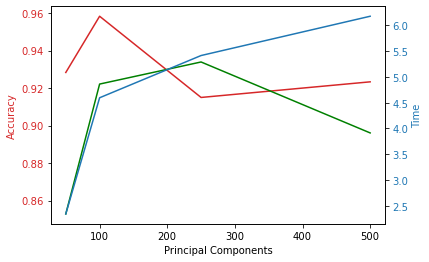

In [146]:
data_sgd = plotPCABpnnClasswise(Xtrain, Xtest, ytrain, ytest, bpnnWith1000Hidden_sgd)

0.8499057212394883


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9535714285714286, 0.9642857142857143, 0.9714285714285714, 0.9642857142857143, 0.9571428571428572, 0.9642857142857143, 0.9571428571428572, 0.7214285714285714, 0.9571428571428572, 0.9464285714285714]
Average Accuracy = 0.9357142857142857
 
            PCA Components 50
            pcaBPNNAccuracy 0.96
            pcaBPNNRunTime 12.164927959442139
            kfoldAcc       0.9357142857142857
            explained      0.8499057212394883
            predicted (0.9688888888888889, 0.9333333333333333)

        
0.9003171949389045


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9607142857142857, 0.9428571428571428, 0.9642857142857143, 0.9571428571428572, 0.9607142857142857, 0.9357142857142857, 0.6892857142857143, 0.9392857142857143, 0.975, 0.95]
Average Accuracy = 0.9274999999999999
 
            PCA Components 100
            pcaBPNNAccuracy 0.965
            pcaBPNNRunTime 10.876703977584839
            kfoldAcc       0.9274999999999999
            explained      0.9003171949389045
            predicted (0.9711111111111111, 0.9466666666666667)

        
0.9535190555850813
Accuracy from each fold =  [0.95, 0.975, 0.9607142857142857, 0.95, 0.9571428571428572, 0.9428571428571428, 0.9571428571428572, 0.9571428571428572, 0.9607142857142857, 0.9571428571428572]
Average Accuracy = 0.9567857142857144
 
            PCA Components 250
            pcaBPNNAccuracy 0.97
            pcaBPNNRunTime 13.811918020248413
            kfoldAcc       0.9567857142857144
            explained      0.9535190555850813
            predicted (0.98, 0.94)


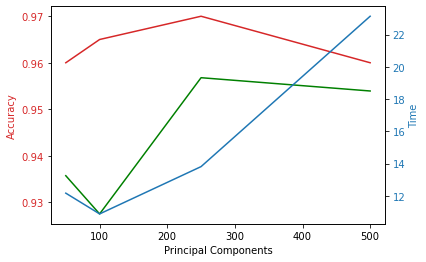

In [149]:
data_lgbfs = plotPCABpnnClasswise(Xtrain, Xtest, ytrain, ytest, bpnnWith1000Hidden_lbfgs)

### Segmentation Experimentation

In [ ]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries

felzen = felzenszwalb(trainingSet[0][101].transpose(), scale=1000, sigma=1)
plt.imshow(mark_boundaries(trainingSet[0][101].transpose(), felzen))
np.unique(felzen, return_counts=True)

from skimage.segmentation import slic
slickBoy = slic((trainingSet[0][101].transpose()), n_segments=100, compactness=10)
plt.imshow(mark_boundaries(trainingSet[0][101].transpose(), slickBoy))

def segmentFeatures(segmentPixels): 
    features = []
    numberPixels, numBands = segmentPixels.shape
    
    for b in np.arange(numBands): 
        stats = scipy.stats.describe(segmentPixels[:,b])
    
    return features

segmentIDs = np.unique(slickBoy)
objects = []
objectIDs = []
for i in segmentIDs: 
    pixels = trainingSet[0][101].transpose()[slickBoy == i] 
    print('pixels for id', i, pixels.shape)
    objectFeatures = segmentFeatures(pixels)
    objects.append(objectFeatures)
    objectIDs.append(i)